In [1]:
# Class for a simple LULCClassifier with 2 conv, 2 pool and 2 fc layers

import torch.nn as nn

class LandUseClassifier(nn.Module):
    def __init__(self):
        super(LandUseClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=32*56*56, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=45)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 32*56*56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [2]:
# Train and evaluate the model
# Also visualize the classification metrics on evaluation of the diff datasets

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def train_evaluate_given_dataset(train_loader, val_loader):
    
    model = LandUseClassifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print("Started training")

    # Train the model
    for epoch in range(8):
        epoch_loss = 0
        print(f"Started epoch {epoch}")
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
    #         print(f"Loss : {loss}")
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch} loss: {epoch_loss/len(train_loader):.4f}")

    print("Training ended")
    
    
    print("Started eval")
    # Evaluate the model on the validation dataset
    y_true = []
    y_pred = []
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true += labels.numpy().tolist()
            y_pred += predicted.numpy().tolist()
    print("Eval ended")
    
    accuracy = 100 * correct / total
    print(f'The accuracy of the baseline classifier on the val dataset is {accuracy:.2f}%')
#     print("Evaluation results for this val dataset")
#     cr = classification_report(y_true, y_pred)
#     print(cr)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(45)))
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

Starting
Length of Original Train Dataset: 15120
Length of Original Validation Dataset: 3780
Running the model and evaluating metrics on original dataset
Started training
Started epoch 0
Epoch 0 loss: 2.9273
Started epoch 1
Epoch 1 loss: 1.8467
Started epoch 2
Epoch 2 loss: 0.8950
Started epoch 3
Epoch 3 loss: 0.3035
Started epoch 4
Epoch 4 loss: 0.1380
Started epoch 5
Epoch 5 loss: 0.0827
Started epoch 6
Epoch 6 loss: 0.0535
Started epoch 7
Epoch 7 loss: 0.0628
Training ended
Started eval
Eval ended
The accuracy of the baseline classifier on the val dataset is 34.97%
Evaluation results for this val dataset
              precision    recall  f1-score   support

           0       0.45      0.27      0.34        74
           1       0.16      0.37      0.22        76
           2       0.61      0.14      0.23        76
           3       0.29      0.16      0.21        98
           4       0.27      0.36      0.31        67
           5       0.30      0.39      0.34        87
      

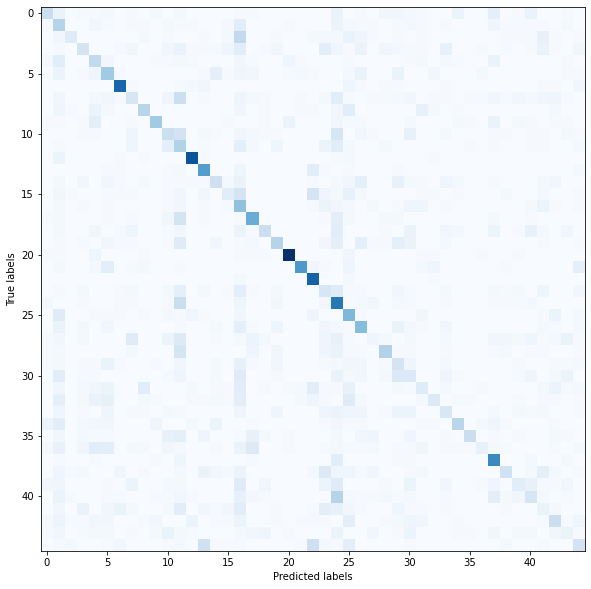

In [6]:
import torch
import torchvision
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.utils.data as data_utils
import math
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Starting")
dataset = datasets.ImageFolder("C:/TUK/Sem 3/Applied AI/Domain Adaptation/NWPU-RESISC45", transform=transform)

# Creating a new subset of the dataset with only 60% the data 
# This is done to avoid insuffiecient memory interruption in execution (while loading the entire datset)
frac_to_keep = 0.6
num_items_to_keep = math.ceil(len(dataset) * frac_to_keep)
indices_to_keep = random.sample(range(len(dataset)), num_items_to_keep)
subset_dataset = data_utils.Subset(dataset, indices_to_keep)

train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size])
print(f"Length of Original Train Dataset: {len(train_dataset)}")
print(f"Length of Original Validation Dataset: {len(val_dataset)}")

batch_size = 32

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Running the model and evaluating metrics on original dataset")
train_evaluate_given_dataset(train_loader, val_loader)

In [7]:
# Visualize samples after applying Gaussian filter
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(train_dataset, tr_datasets_filtered):

    n_samples = 4
    fig, axes = plt.subplots(n_samples, 4, figsize=(10, 10))
    for i in range(n_samples):
        # plot original image
        img = np.transpose(train_dataset[i][0], (1, 2, 0))
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        # plot filtered images with radii
        for j, r in enumerate(filters):
            f_img = np.transpose(tr_datasets_filtered[j][i][0], (1, 2, 0))
            axes[i, j+1].imshow(f_img)
            axes[i, j+1].set_title(f'Radius = {r}')
            axes[i, j+1].axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Created 3 subsets after applying Guassian low-pass filter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

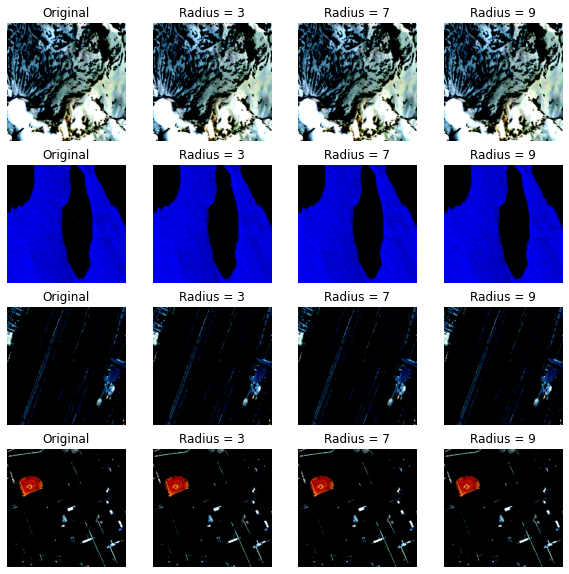

Original sample:
 - image shape: torch.Size([3, 224, 224])
 - label: 37
Filtered sample (radius = 3):
 - image shape: torch.Size([3, 224, 224])
 - label: 37
Running the model and evaluating metrics on filtered dataset with radii 3
Started training
Started epoch 0
Epoch 0 loss: 3.0239
Started epoch 1
Epoch 1 loss: 2.0267
Started epoch 2
Epoch 2 loss: 1.0207
Started epoch 3
Epoch 3 loss: 0.3292
Started epoch 4
Epoch 4 loss: 0.1301
Started epoch 5
Epoch 5 loss: 0.0609
Started epoch 6
Epoch 6 loss: 0.0626
Started epoch 7
Epoch 7 loss: 0.0528
Training ended
Started eval
Eval ended
The accuracy of the baseline classifier on the val dataset is 37.59%
Evaluation results for this val dataset
              precision    recall  f1-score   support

           0       0.32      0.39      0.35        74
           1       0.17      0.34      0.23        76
           2       0.26      0.25      0.26        76
           3       0.33      0.03      0.06        98
           4       0.47      0.46    

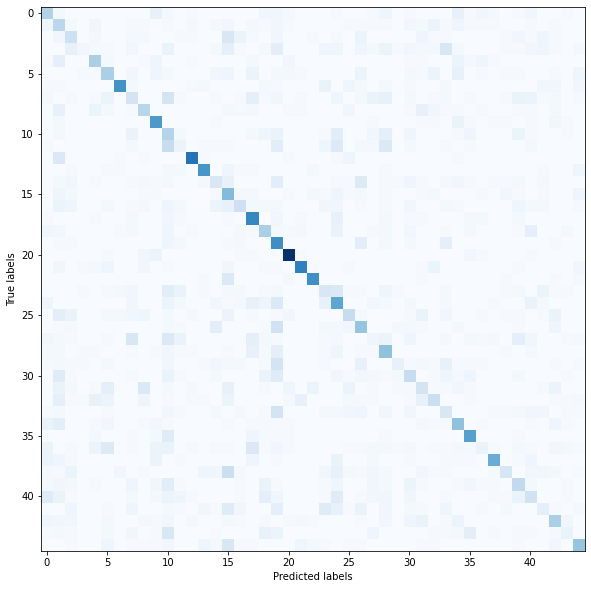

Running the model and evaluating metrics on filtered dataset with radii 7
Started training
Started epoch 0
Epoch 0 loss: 3.2350
Started epoch 1
Epoch 1 loss: 2.2040
Started epoch 2
Epoch 2 loss: 1.2538
Started epoch 3
Epoch 3 loss: 0.4141
Started epoch 4
Epoch 4 loss: 0.1360
Started epoch 5
Epoch 5 loss: 0.0749
Started epoch 6
Epoch 6 loss: 0.0640
Started epoch 7
Epoch 7 loss: 0.0731
Training ended
Started eval
Eval ended
The accuracy of the baseline classifier on the val dataset is 30.26%
Evaluation results for this val dataset
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        74
           1       0.21      0.13      0.16        76
           2       0.17      0.32      0.22        76
           3       0.18      0.17      0.18        98
           4       0.45      0.22      0.30        67
           5       0.23      0.29      0.26        87
           6       0.94      0.54      0.69        94
           7       0.24      0.1

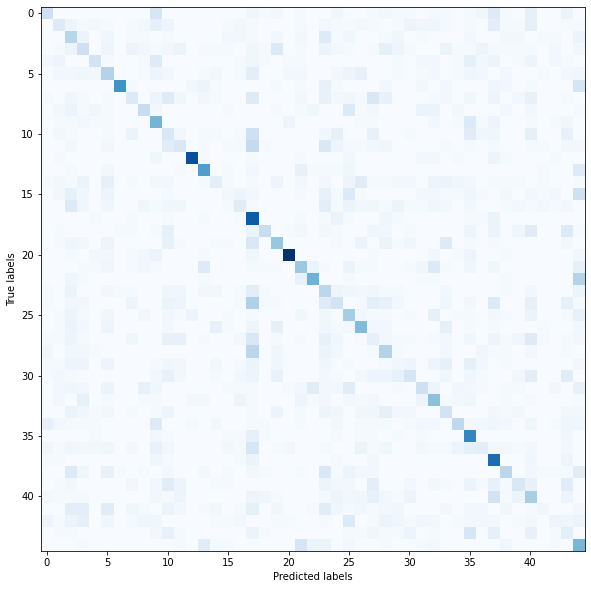

Running the model and evaluating metrics on filtered dataset with radii 9
Started training
Started epoch 0
Epoch 0 loss: 2.9434
Started epoch 1
Epoch 1 loss: 1.9451
Started epoch 2
Epoch 2 loss: 1.0035
Started epoch 3
Epoch 3 loss: 0.3594
Started epoch 4
Epoch 4 loss: 0.1509
Started epoch 5
Epoch 5 loss: 0.0651
Started epoch 6
Epoch 6 loss: 0.0578
Started epoch 7
Epoch 7 loss: 0.0567
Training ended
Started eval
Eval ended
The accuracy of the baseline classifier on the val dataset is 34.18%
Evaluation results for this val dataset
              precision    recall  f1-score   support

           0       0.35      0.22      0.27        74
           1       0.16      0.59      0.25        76
           2       0.17      0.46      0.25        76
           3       0.16      0.17      0.17        98
           4       0.30      0.33      0.31        67
           5       0.53      0.20      0.29        87
           6       0.87      0.65      0.74        94
           7       0.40      0.0

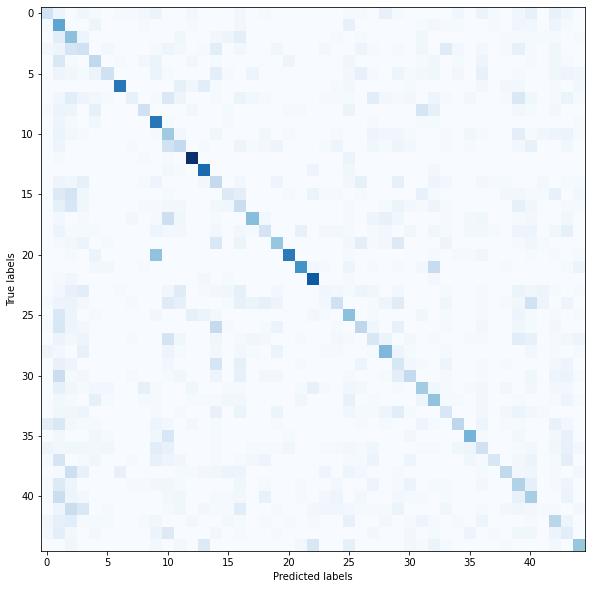

In [9]:
# Applying Gaussian low-pass filter of 3 different radii to the dataset
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

filters = [3, 7, 9]
tr_datasets_filtered = []
val_datasets_filtered = []
for r in filters:
    transform = transforms.Compose([
        transforms.GaussianBlur(kernel_size=r),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    tr_filtered_dataset = copy.deepcopy(train_dataset)
    tr_filtered_dataset.transform = transform
    tr_datasets_filtered.append(tr_filtered_dataset)

    val_filtered_dataset = copy.deepcopy(val_dataset)
    val_filtered_dataset.transform = transform
    val_datasets_filtered.append(val_filtered_dataset)
    

print("Created 3 subsets after applying Guassian low-pass filter")    
visualize_samples(train_dataset, tr_datasets_filtered)
    
# Print the label and shape to verify transformations
original_sample = train_dataset[0]
filtered_sample = tr_datasets_filtered[0][0]

print('Original sample:')
print(' - image shape:', original_sample[0].shape)
print(' - label:', original_sample[1])

print('Filtered sample (radius = 3):')
print(' - image shape:', filtered_sample[0].shape)
print(' - label:', filtered_sample[1])


# Trying out for 1    
# tr_loader_filtered = torch.utils.data.DataLoader(tr_datasets_filtered[0], batch_size=32, shuffle=True)
# val_loader_filtered = torch.utils.data.DataLoader(val_datasets_filtered[0], batch_size=32, shuffle=False)
# train_evaluate_given_dataset(tr_loader_filtered, val_loader_filtered)

# Train the baseline LULC classifier on each of the filtered datasets
for i in range(len(filters)):
    print(f"Running the model and evaluating metrics on filtered dataset with radii {filters[i]}")
    # Create dataloaders
    tr_loader_filtered = torch.utils.data.DataLoader(tr_datasets_filtered[i], batch_size=32, shuffle=True)
    val_loader_filtered = torch.utils.data.DataLoader(val_datasets_filtered[i], batch_size=32, shuffle=False)
    
    train_evaluate_given_dataset(tr_loader_filtered, val_loader_filtered)
    
    